# Loading Dataset and creating model

```
pip install catboost
pip install shap
pip install dalex
```



In [9]:
# Importing and installing libraries for model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
from sklearn.model_selection import *
import catboost
from catboost import CatBoostClassifier

In [12]:
# loading dataset
df = pd.read_csv("BankChurners.csv")
df.drop(["CLIENTNUM","Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2","Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1"],axis=1,inplace=True)
df.head()

Attrition_Flag  Customer_Age  ... Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio
0  Existing Customer            45  ...               1.625                  0.061
1  Existing Customer            49  ...               3.714                  0.105
2  Existing Customer            51  ...               2.333                  0.000
3  Existing Customer            40  ...               2.333                  0.760
4  Existing Customer            40  ...               2.500                  0.000

[5 rows x 20 columns]

In [13]:
# % of class distribution
classCount = df['Attrition_Flag'].value_counts().to_dict()
print("% for Existing Customers", classCount['Existing Customer']/df.shape[0]*100)
print("% for Churned Customers", classCount['Attrited Customer']/df.shape[0]*100)

% for Existing Customers 83.934037720944
% for Churned Customers 16.065962279055988


In [17]:
# 1 Denotes existing customer
# 0 Denotes churned customer
x = df.drop(['Attrition_Flag'],axis=1)
le = LabelEncoder()
y = le.fit_transform(df["Attrition_Flag"])
x = pd.get_dummies(x,drop_first=True)

In [18]:
# Train Test Split iin 75:25
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=27,stratify=y)
params = {'task_type':'GPU','iterations':1000,'learning_rate':0.1,
          'depth':2,'eval_metric':'AUC',
          'verbose':100,'random_seed': 1 
}
# Train a catboost model using Smote Technique to handle class imbalancy
# Catboost is a tree based learning so using smote or not won't affect much
sm = SMOTE(random_state=27, ratio=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)
cat_model1 = CatBoostClassifier(**params)
cat_model1.fit(X_train,
               y_train,
               eval_set=(X_test, y_test),
               use_best_model=True,
               early_stopping_rounds=50,
               plot=True )
y_pred = cat_model1.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8648270	test: 0.8485498	best: 0.8485498 (0)	total: 21.6ms	remaining: 21.5s
100:	learn: 0.9971416	test: 0.9818309	best: 0.9818309 (100)	total: 1.9s	remaining: 16.9s
200:	learn: 0.9982717	test: 0.9869542	best: 0.9869542 (200)	total: 3.61s	remaining: 14.4s
300:	learn: 0.9987050	test: 0.9889325	best: 0.9889498 (299)	total: 5.42s	remaining: 12.6s
400:	learn: 0.9989932	test: 0.9906923	best: 0.9906923 (400)	total: 7.28s	remaining: 10.9s
500:	learn: 0.9991641	test: 0.9914600	best: 0.9914600 (500)	total: 9.06s	remaining: 9.02s
600:	learn: 0.9992844	test: 0.9919017	best: 0.9919098 (597)	total: 11s	remaining: 7.32s
700:	learn: 0.9993589	test: 0.9922336	best: 0.9922625 (688)	total: 13s	remaining: 5.53s
800:	learn: 0.9994074	test: 0.9924775	best: 0.9924775 (800)	total: 15s	remaining: 3.72s
900:	learn: 0.9994637	test: 0.9924787	best: 0.9925504 (856)	total: 16.9s	remaining: 1.86s
bestTest = 0.9925503731
bestIteration = 856
Shrink model to first 857 iterations.


In [19]:
cm_cat = confusion_matrix(y_test,y_pred)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 357   50]
 [  23 2102]]
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       407
           1       0.98      0.99      0.98      2125

    accuracy                           0.97      2532
   macro avg       0.96      0.93      0.95      2532
weighted avg       0.97      0.97      0.97      2532



# Insights in Model

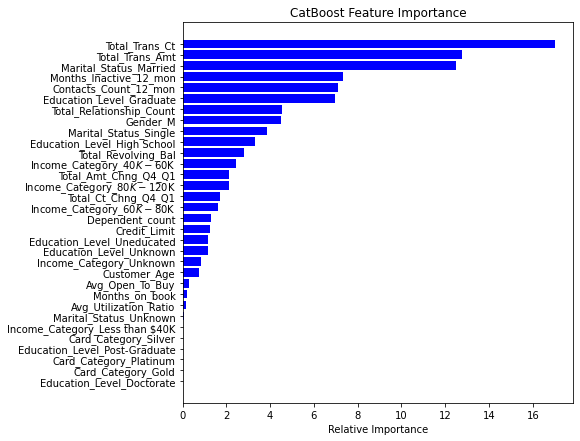

In [88]:
# Feature importance from model 
plt.rcParams["figure.figsize"] = (7,7)
importances = cat_model1.feature_importances_
indices = np.argsort(importances)
features = x.columns
plt.title('CatBoost Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Top 3 Features - 
# Top Trans CT 
# Total Trans Amt
# Marital Status Married

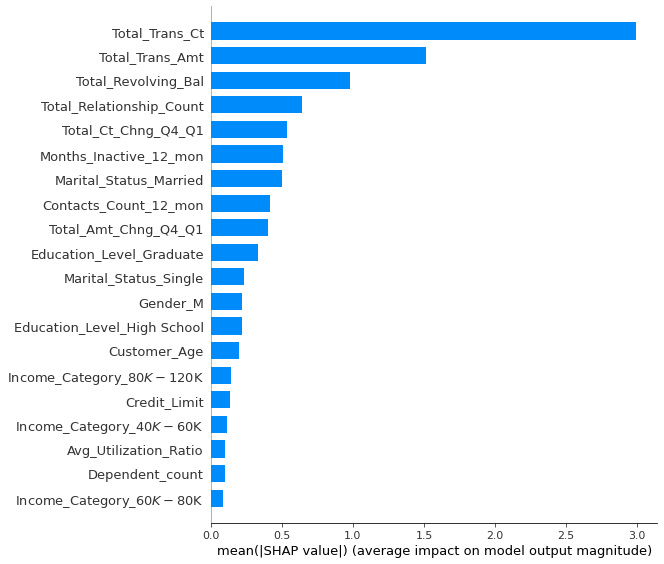

In [90]:
# Feature importance using SHAPLEY values derived from CAT BOOST model
import shap
shap_values = shap.TreeExplainer(cat_model1).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar",max_display=20,feature_names=x.columns)
# Top 3 Features - 
# Top Trans CT 
# Total Trans Amt
# Total_Revolving_Bal
# Feature importance came out to be different in case of using shapley values v/s catboost weights

# Global Explaination

---
<h4>The below summary plot gives us various insights in model and data wiith respect to the target class. It can help us to derive various rules for explaination with respect to each feature</h4>


---



As we have been observing in above feature importance graphs that <b>Total_Trans_Ct</b> was the most important feature.<br> We can verfify the same using <b><i>Shap Global Explaination</i></b>
So let's derive some rules where the most important feature is not <b>Total_Trans_Ct</b>.

---

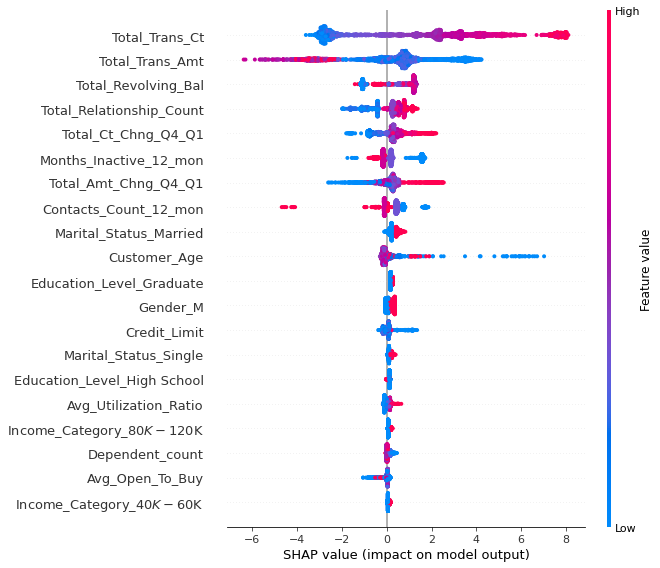

In [139]:
from catboost import CatBoostClassifier, Pool
shap_values = cat_model1.get_feature_importance(Pool(X_test, label=y_test) ,type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
shap.summary_plot(shap_values, X_test,max_display=20)

#Rules using SHAP 's Global Explanation
---
<h3><i>On analysing below dependence plots we can derive certain thresholds which can be used to rectify data/model and even verify prediction in the T/F - P/N Cases:<i></h3>

---
---
*   **Threshold value for total_trans_ct > 60**
---
*   **Threshold value for Trans_amt between 1500 and 5000**

---


*   **Threshold value for revolving bal between 700 and 2300**
---
*   **Threshold value for Relationship count>=3**
---
*   **Threshold value for ct_chng_q4_q1 >0.7**
---
*   **Threshold value for Total amt chng >1.0**
---

One could analyse and derive any number of rules for any sort of explaination in relation to features






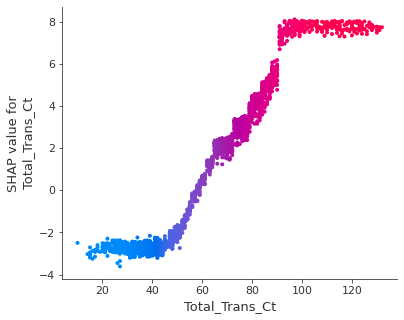

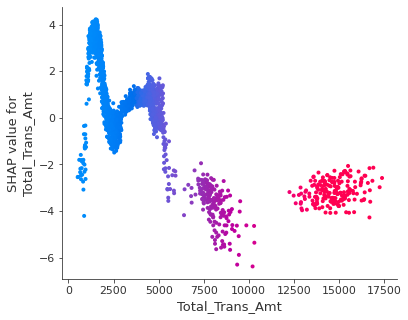

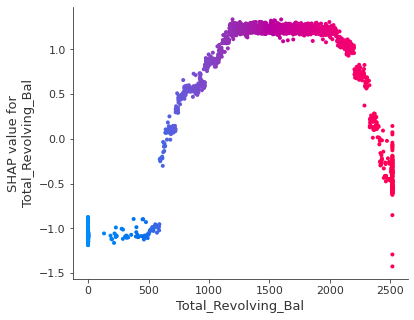

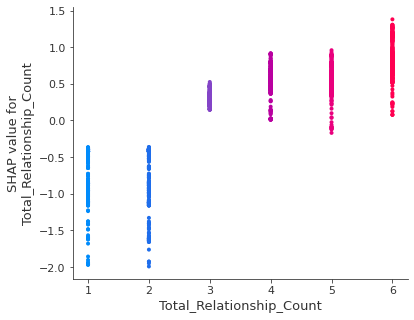

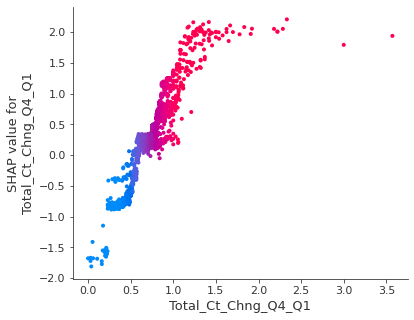

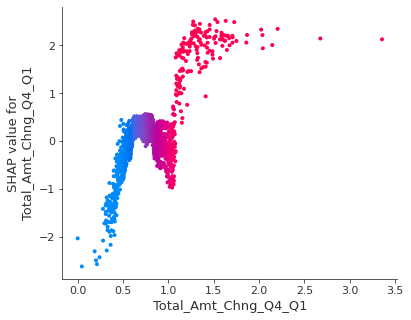

In [95]:
shap.dependence_plot("Total_Trans_Ct", shap_values, X_test,interaction_index= 'Total_Trans_Ct')
shap.dependence_plot('Total_Trans_Amt', shap_values, X_test,interaction_index='Total_Trans_Amt')
shap.dependence_plot('Total_Revolving_Bal', shap_values, X_test,interaction_index='Total_Revolving_Bal')
shap.dependence_plot('Total_Relationship_Count', shap_values, X_test,interaction_index='Total_Relationship_Count')
shap.dependence_plot('Total_Ct_Chng_Q4_Q1', shap_values, X_test,interaction_index='Total_Ct_Chng_Q4_Q1')
shap.dependence_plot('Total_Amt_Chng_Q4_Q1', shap_values, X_test,interaction_index='Total_Amt_Chng_Q4_Q1')

# Finding Instances based on explanation
---
<h4><b>Applying above formed rules to find out the instances in :</b></h4>



1.   True Positive
2.   True Negatives
3.   False Positives
4.   False Negatives


---


```
shapDF =pd.DataFrame(shap_values,columns=x.columns)
shapDF['y_test'] = y_test
shapDF['y_pred'] = y_pred
```




In [98]:
shapDF =pd.DataFrame(shap_values,columns=x.columns)
shapDF['y_test'] = y_test
shapDF['y_pred'] = y_pred

In [97]:
#True Positives
shapDF.loc[ shapDF.Total_Trans_Ct.between(-0.5,0.5)][['Total_Trans_Ct','Total_Trans_Amt','y_test','y_pred']].head()

Total_Trans_Ct  Total_Trans_Amt  y_test  y_pred
50         0.178789         2.930237       1       1
53         0.036260         0.462268       1       1
65         0.186797         2.530782       1       1
90        -0.108388         0.068420       1       1
131       -0.093239         0.625223       1       1

In [99]:
#True Negatives
shapDF.loc[ shapDF.Total_Trans_Amt.between(-6,-4) & \
           shapDF.Total_Trans_Ct.between(-0.5,0.5)][['Total_Trans_Ct','Total_Trans_Amt','y_test','y_pred']]

Total_Trans_Ct  Total_Trans_Amt  y_test  y_pred
159        -0.055411        -4.630131       0       0
990        -0.490049        -4.617869       0       0
1362       -0.169217        -4.509663       0       0
1684        0.303146        -4.643502       0       0

In [100]:
#False Positives
shapDF.loc[ shapDF.Total_Trans_Ct.between(-0.5,0.5) & \
           shapDF.y_test.between(0,0) & shapDF.y_pred.between(1,1)][['Total_Trans_Ct','Total_Trans_Amt','y_test','y_pred']].head()

Total_Trans_Ct  Total_Trans_Amt  y_test  y_pred
252        -0.028622        -0.212908       0       1
264         0.394816        -0.776284       0       1
1228       -0.340826        -0.426404       0       1
1451        0.117756         0.497937       0       1
1536       -0.195898         0.793408       0       1

In [101]:
#False Negatives
shapDF.loc[shapDF.Total_Trans_Ct.between(-1,1) & \
           shapDF.y_test.between(1,1) & shapDF.y_pred.between(0,0)][['Total_Trans_Ct','Total_Trans_Amt','y_test','y_pred']].head()

Total_Trans_Ct  Total_Trans_Amt  y_test  y_pred
207        -0.301738         0.448195       1       0
1197       -0.952344         0.434289       1       0
1744        0.215900        -1.104757       1       0

#Local Explanation on the procured Instances

For this part of code you'll need to install these packages in order to proceed
```
pip install lime
pip install anchor-exp
pip install dalex
```



In [104]:
import lime
import lime.lime_tabular
from anchor import utils
from anchor import anchor_tabular
import dalex as dx

In [113]:
# Initilzing explainer instances objects of all the 3 frameworks
lime_explain = lime.lime_tabular.LimeTabularExplainer(X_test.to_numpy(), feature_names=x.columns,class_names=['Churned','Existing'], discretize_continuous=True)
anchor_explain = anchor_tabular.AnchorTabularExplainer(['0','1'],x.columns, X_train)
dalex_explain = dx.Explainer(cat_model1, X_test, y_test)

Preparation of a new explainer is initiated

  -> data              : 2532 rows 32 cols
  -> target variable   : 2532 values
  -> model_class       : catboost.core.CatBoostClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7fa83d675730> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 8.1e-05, mean = 0.843, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.989, mean = -0.00329, max = 0.956
  -> model_info        : package catboost

A new explainer has been created!


## Explanations

<b><h4><i>To find explanation for instances not having Total_Trans_Ct more important we need to go from Global Explanation to Local Explanation</i></h4></b>

---
Applying below code functionalities using 4 frameworks, we can locally explain any instance of dataset and find the features respective to the target class


---


The main reason to switch to local explanation is that Global Explanation doesn't consider the target class for each dependency and is not able to detect outlier explantions

1. [SHAP](https://dalex.drwhy.ai/)

2. [Lime](https://arxiv.org/pdf/1602.04938.pdf)

3. [Anchor](https://homes.cs.washington.edu/~marcotcr/aaai18.pdf)

4. [Dalex](https://dalex.drwhy.ai/)

<i>The above 4 frameworks have been used to apply local explanability. To study more about them and for referencs you can click on the links attached to each</i>

In [126]:
def explainer(instance,framework='lime'):
  if framework == 'shap':
    shap.initjs()
    return shap.force_plot(expected_value, shap_values[instance,:], X_test.iloc[instance,:])
  elif framework == 'lime':
    expr = lime_explain.explain_instance(X_test.to_numpy()[instance], cat_model1.predict_proba, num_features=9)
    return expr.show_in_notebook()
  elif framework == 'anchor':
    expr = anchor_explain.explain_instance(X_test.to_numpy()[instance], cat_model1.predict, threshold=0.95)
    return expr.show_in_notebook()
  elif framework == 'dalex':
    expr = dalex_explain.predict_parts(X_test.to_numpy()[instance], type = 'break_down_interactions')
    return expr.plot(max_vars=9)
  else:
    print("Please choose from ['lime', 'anchor', 'dalex', 'shap']")

In [138]:
# 159 is a True Positive Instance
explainer(159,'shap') #SHAP

In [128]:
explainer(159,'lime') #Lime Framework

In [137]:
explainer(159,'anchor') #Anchor Framework

In [129]:
explainer(159,'dalex') #Dalex
# 